In [1]:
#dataframe
import pandas as pd

#plots
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

#model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


#model assessment
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#dealing with class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#tuning
from sklearn.model_selection import GridSearchCV

In [2]:
#pip install -U imbalanced-learn

In [3]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


<h3> Classes are inherently imbalanced

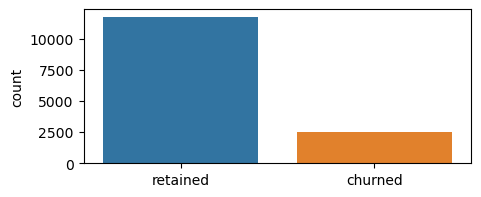

In [4]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [5]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [6]:
print(churn_count)

2536


In [7]:
churn_count/retained_count

0.21559126073280627

In [8]:
#The above cells show that the data is unbalanced. 
#Resample to balance classes. 

In [9]:
#convert values in label column to 1 (churned) or 0 (retained)
waze_cleaned['label']= waze_cleaned['label'].apply(lambda x: True if x == 'churned' else False).astype(int)
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,0,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,0,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


<h3> Split data into testing and training datasets and standardize

In [10]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


In [11]:
# Undersample data to Change balance of imbalanced classes in dependent variable 
# sampling_strategy = .5
# rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state = 42)
# X_train_scaled_res, y_res = rus.fit_resample(X_train_scaled, y_train)

In [12]:
# Oversample data to Change balance of imbalanced classes in dependent variable 
#sampling_strategy = .5
ros = RandomOverSampler(sampling_strategy=.5, random_state = 42)
X_train_scaled_res, y_res = ros.fit_resample(X_train_scaled, y_train)

In [13]:
y_res.value_counts()

label
0    9426
1    4713
Name: count, dtype: int64

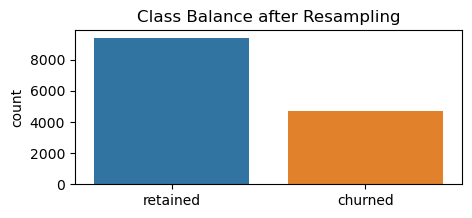

In [14]:
# Convert y_res to a DataFrame for visualization
y_res_df = pd.DataFrame(y_res, columns=['label'])

# Visualize the new class balance
plt.figure(figsize = (5, 2))
sns.countplot(x = y_res_df["label"])
plt.xlabel("")
plt.xticks([0, 1], ['retained', 'churned'])
plt.title("Class Balance after Resampling")
plt.show()

In [15]:
retained_count = y_res_df["label"].value_counts().get(0, 0)
churn_count = y_res_df["label"].value_counts().get(1, 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 9426
Total churn count: 4713
Churn rate 0.33


In [16]:
#rename variables to those used before resampling
X_train_scaled = X_train_scaled_res
y_train = y_res

<h1> Logistic Regression

In [17]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state = 42)
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=42, solver='liblinear')

In [18]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.7842657342657343
train accuracy: 0.7204894264092228


While checking for accuracy is only the first step, the well matched train/test accuracy (low variance, with only slightly higher accuracy for training set) is a good start with no obvious over/underfitting. I tried a confusion matrix and got array([[  34,  463],
       [  39, 2324]]), then different results, so went back and set a random state of 42 for consistent results

In [19]:
cm = confusion_matrix(y_test, y_predict, labels = clf_lr.classes_)
cm

array([[2000,  337],
       [ 280,  243]])

In [20]:
# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value using accuracy scoring is: {best_C}")

The best C value using accuracy scoring is: 0.004832930238571752


In [21]:
#reattempt using recall as scoring method
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value using recall scoring is: {best_C}")


The best C value using recall scoring is: 0.0001


In [22]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(C = .0001, solver = 'liblinear', max_iter = 500, random_state = 42)
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0001, max_iter=500, random_state=42, solver='liblinear')

In [23]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.7377622377622378
train accuracy: 0.7074757762217979


In [45]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_recall = recall_score(y_train, y_train_predicted)

print("test recall:", test_recall)
print("train recall:", train_recall)

test recall: 0.5831739961759083
train recall: 0.5913430935709739


In [46]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      2337
           1       0.36      0.58      0.45       523

    accuracy                           0.74      2860
   macro avg       0.63      0.68      0.64      2860
weighted avg       0.80      0.74      0.76      2860



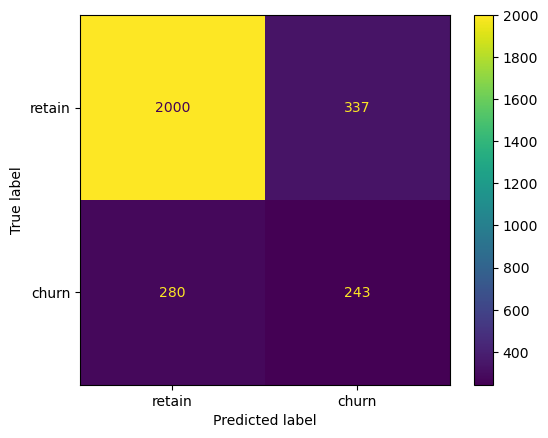

In [25]:
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

In [26]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      2337
           1       0.36      0.58      0.45       523

    accuracy                           0.74      2860
   macro avg       0.63      0.68      0.64      2860
weighted avg       0.80      0.74      0.76      2860



<h1> K Nearest Neighbors 

In [27]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=4)

In [28]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.7531468531468531
train accuracy: 0.8697220454063229


In [29]:
#Predict y test and check recall on predicting test set
y_predict = knn.predict(X_test_scaled)
test_recall = recall_score(y_test, y_predict)

#check recall of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_recall = recall_score(y_train, y_train_predicted)

print("test recall:", test_recall)
print("train recall:", train_recall)

test recall: 0.3231357552581262
train recall: 0.7740292807129217


In [30]:
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2337
           1       0.32      0.32      0.32       523

    accuracy                           0.75      2860
   macro avg       0.59      0.59      0.59      2860
weighted avg       0.75      0.75      0.75      2860



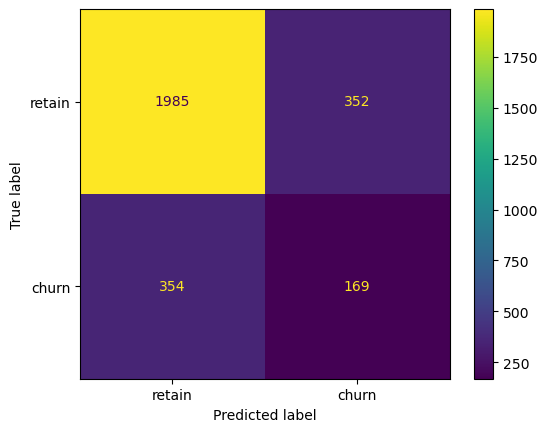

In [31]:
cm = confusion_matrix(y_test, y_predict, labels = knn.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

<h2> Random Forest

In [32]:
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
clf_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [33]:
y_predict = clf_rf.predict(X_test_scaled)
ac = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict, average='weighted')
test_accuracy = accuracy_score(y_test, y_predict)
print('Random Forest Accuracy = ', ac)
print('Random Forest f1-score =' , f1)

Random Forest Accuracy =  0.813986013986014
Random Forest f1-score = 0.779944462529552


In [34]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[2228,  109],
       [ 423,  100]])

In [35]:
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

In [36]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2337
           1       0.48      0.19      0.27       523

    accuracy                           0.81      2860
   macro avg       0.66      0.57      0.58      2860
weighted avg       0.77      0.81      0.78      2860



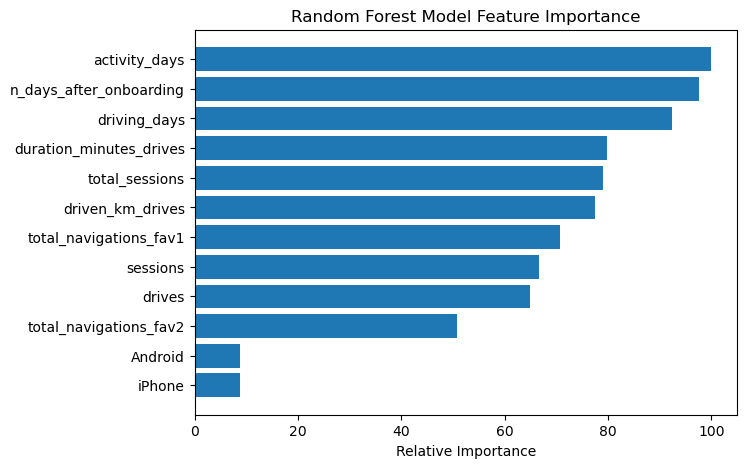

In [47]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model Feature Importance')
plt.show();

<h2> Gradient Boost with XGBoost

In [44]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
clf_xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [43]:
y_predict = clf_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_predict))
cm = confusion_matrix(y_test, y_predict)
cm

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2337
           1       0.39      0.32      0.35       523

    accuracy                           0.78      2860
   macro avg       0.62      0.60      0.61      2860
weighted avg       0.77      0.78      0.78      2860



array([[2079,  258],
       [ 357,  166]])

In [40]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_xgb.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_xgb.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.784965034965035
train accuracy: 0.9400240469623028


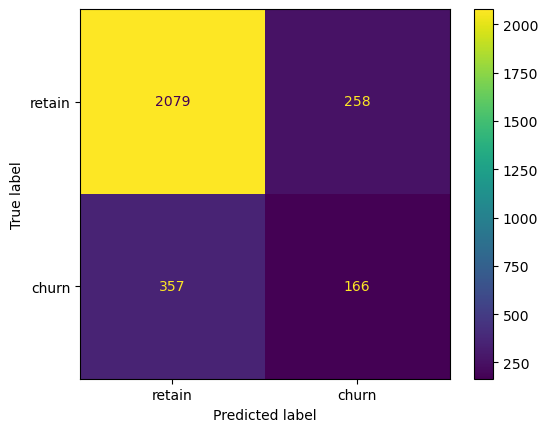

In [41]:
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = ['retain', 'churn'])
display_cm.plot(ax = ax);

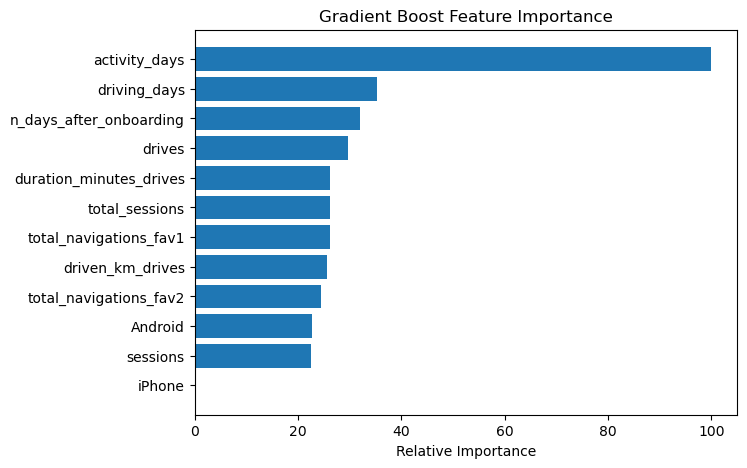

In [48]:
feature_importance = clf_xgb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boost Feature Importance')
plt.show();

Conclusion: Even without optimization, the gradient boost model gives the best results. As our primary business interest is to identify churn, we prioritize sensitivity (recall), the true positive rate. 

The random forest model had very slightly higher scores for precision and the related score f1. It might be worthwhile to discuss how the model results will be used with stakeholders. If the planned intervention on customers at risk of churn is expensive or limited, elevating the importance of precision may be warranted. 